# 03 Running a simulation

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import jellybamm
import liionpack as lp
import pybamm
import numpy as np

In [2]:
pybamm.__version__

'23.9'

{'alpha_radial': 0.00012997486546235373, 'alpha_spiral': 0.0018925822276459076, 'lump_rho': 2499.316300105252, 'lump_Cp': 8247.24639489116}


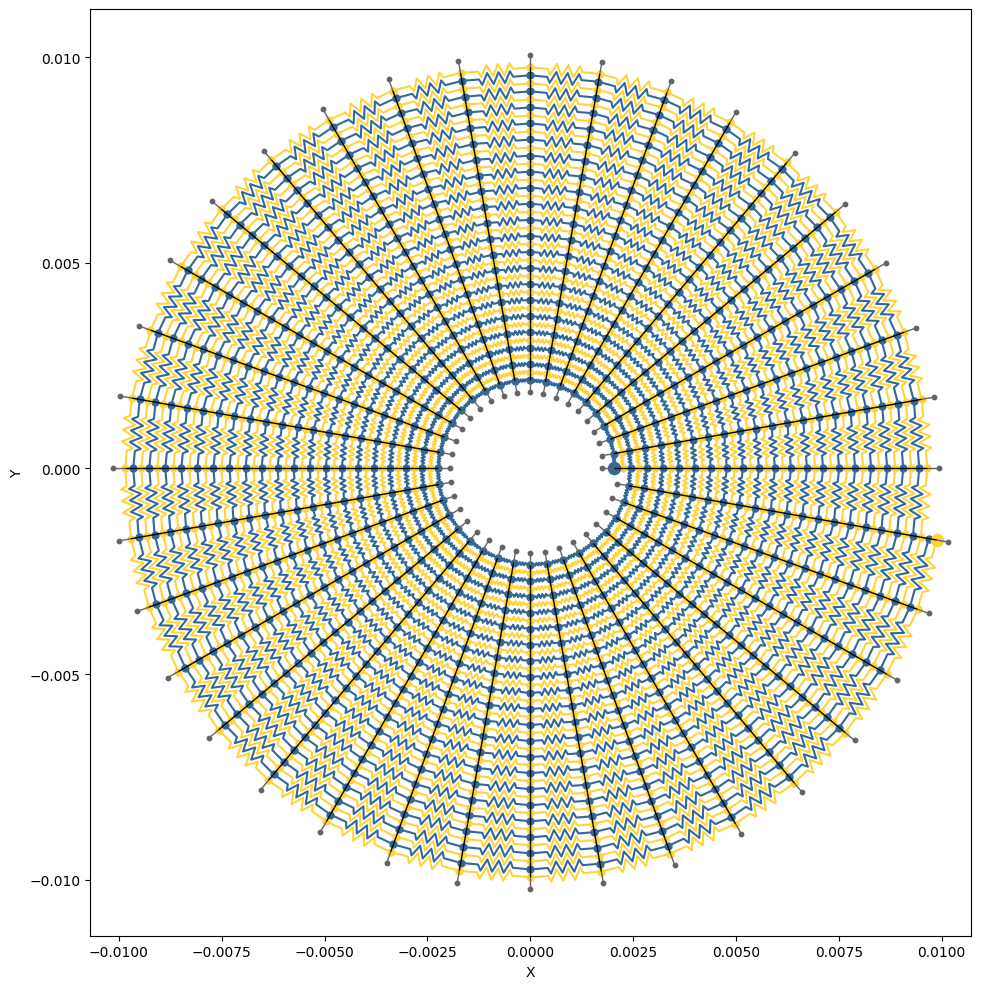

In [4]:
# pybamm.set_logging_level("INFO")
wrk = op.Workspace()
wrk.clear()
wrk.settings["loglevel"] = 100

# Geometry of spiral
Nlayers = 20
dtheta = 10
spacing = 195e-6  # To do should come from params
inner_r = 10 * spacing
pos_tabs = [-1]
neg_tabs = [0]
length_3d = 0.08
tesla_tabs = False

# Experiment
I_app = 4.0
dt = 5
Nsteps = 36
hours = dt * Nsteps / 3600
experiment = pybamm.Experiment(
    [
        f"Discharge at {I_app} A for {hours} hours",
    ],
    period=f"{dt} seconds",
)

# OpenPNM project
project, arc_edges = jellybamm.make_spiral_net(
    Nlayers, dtheta, spacing, inner_r, pos_tabs, neg_tabs, length_3d, tesla_tabs
)
jellybamm.plot_topology(project.network)
# Parameter set
param = pybamm.ParameterValues("Chen2020")
# JellyBaMM discretises the spiral using the electrode height for spiral length
# This parameter set has the longer length set to the Electrode width
# We want to swap this round
param["Electrode width [m]"] = length_3d
# Passing None as initial_soc will take values from Parameter set and apply
# uniformly everywhere
initial_soc = 0.5
thermal_props = print(jellybamm.lump_thermal_props(param))

Stepping simulation: 100%|██████████| 37/37 [00:25<00:00,  1.46it/s]

******************************
ECM Sim time 31.030439376831055
******************************


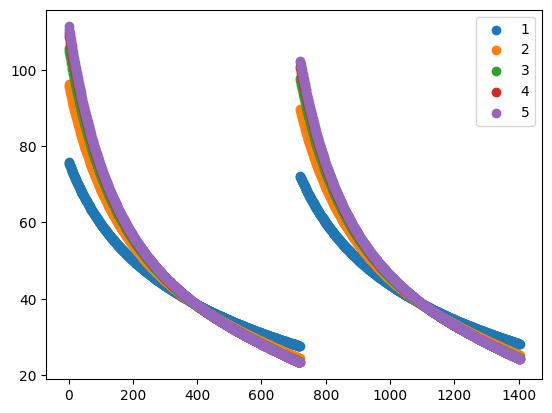

In [5]:
# Run simulation
project, output = jellybamm.run_simulation_lp(
    parameter_values=param, experiment=experiment, initial_soc=None, project=project
)

In [7]:
net = project.network
net.num_pores("free_stream")

36

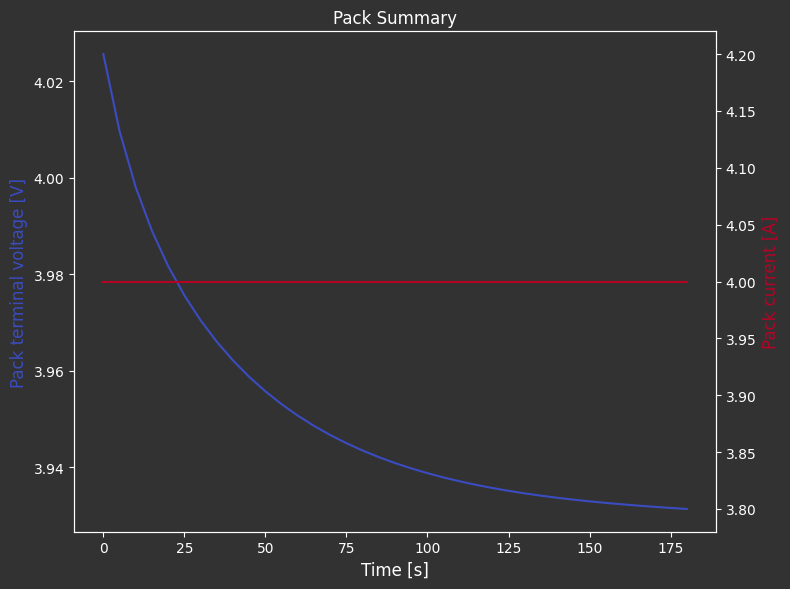

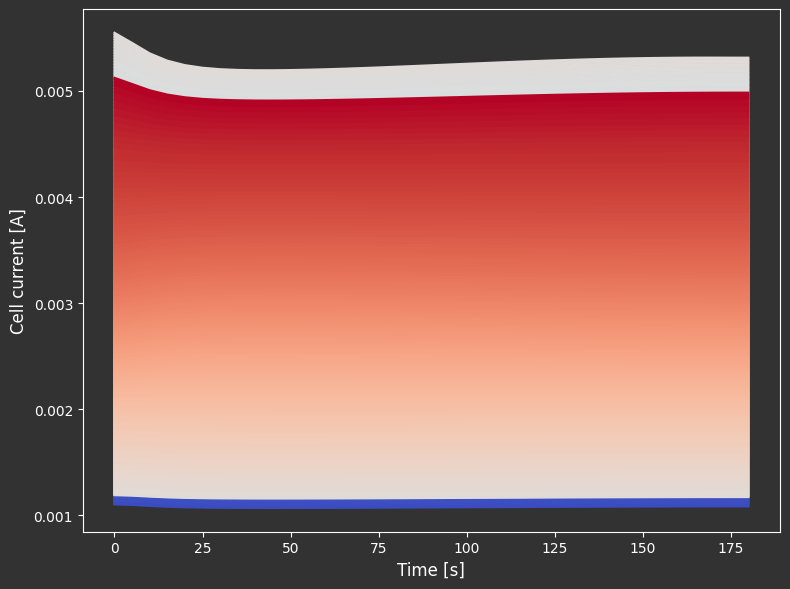

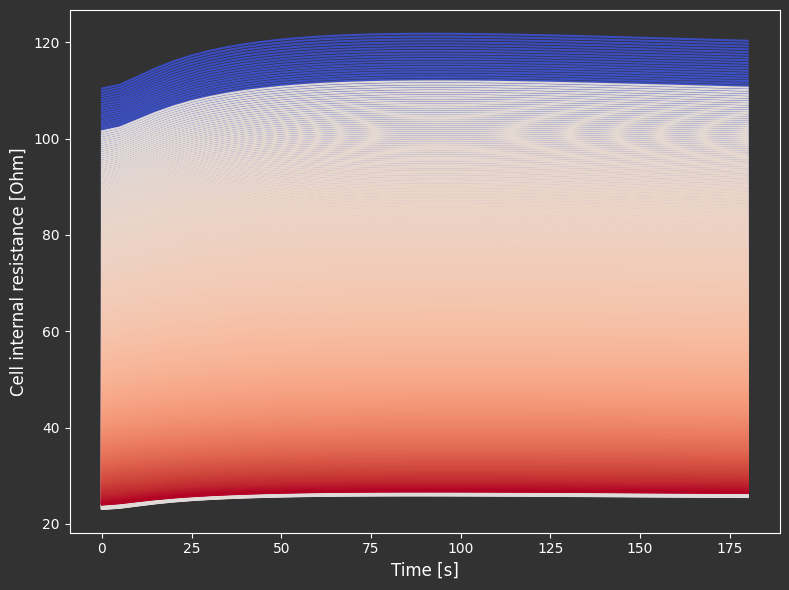

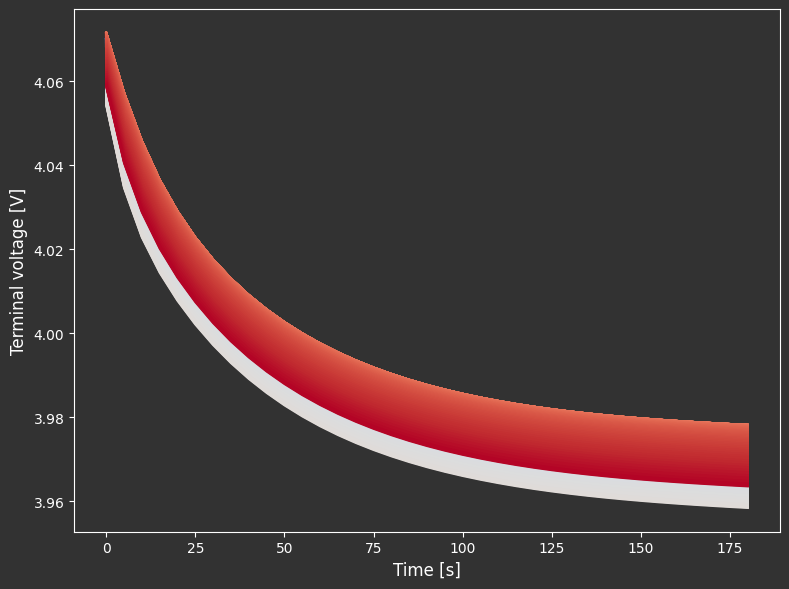

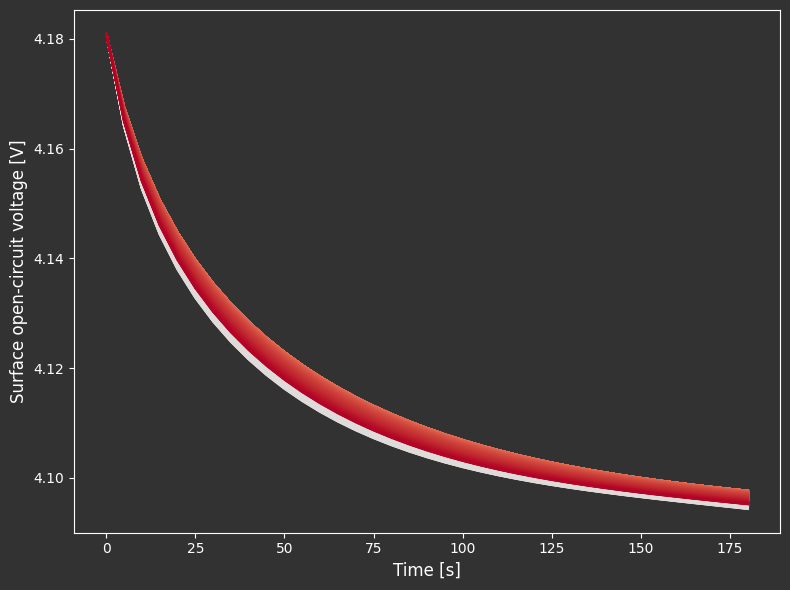

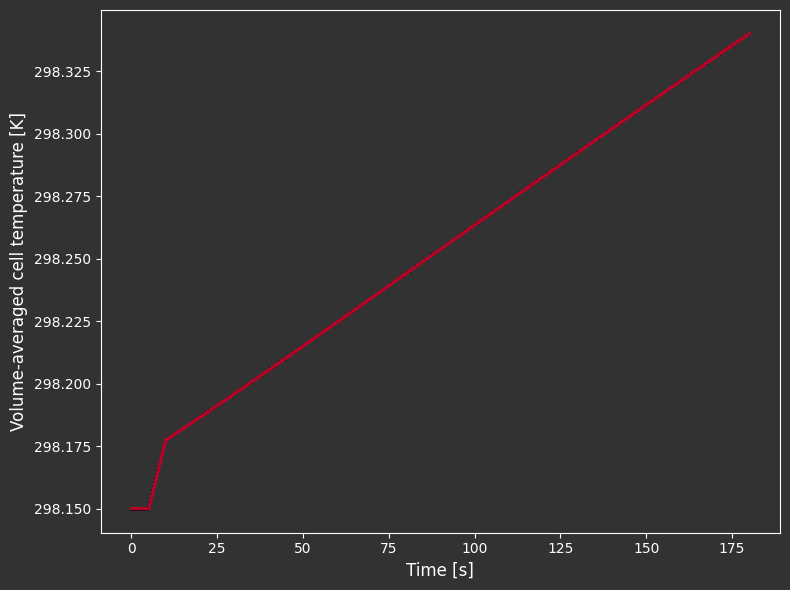

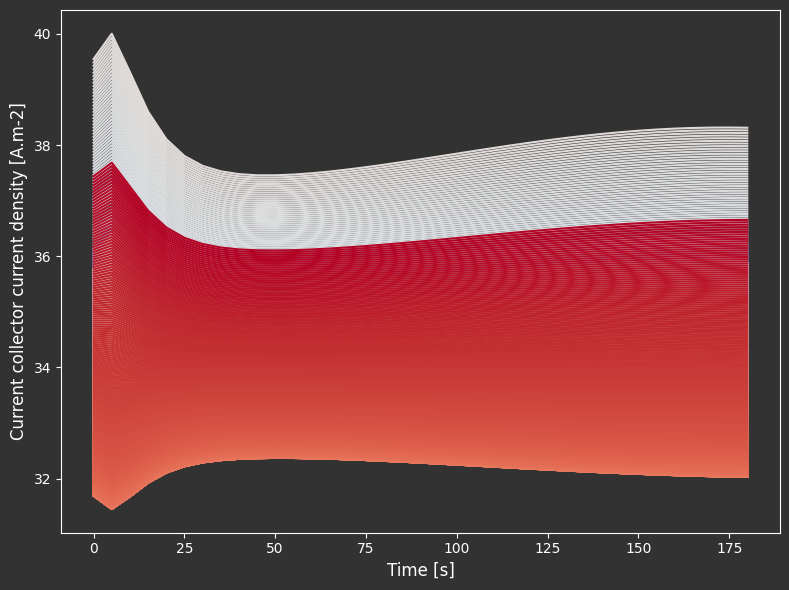

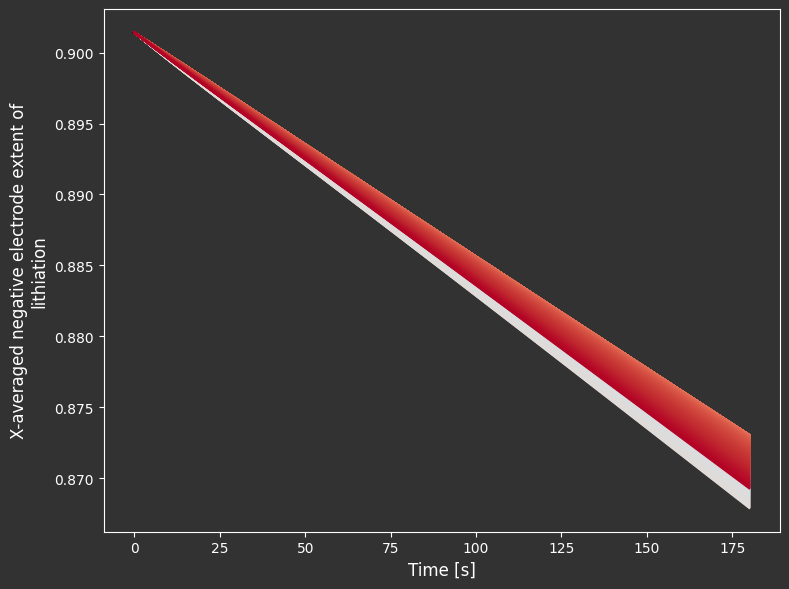

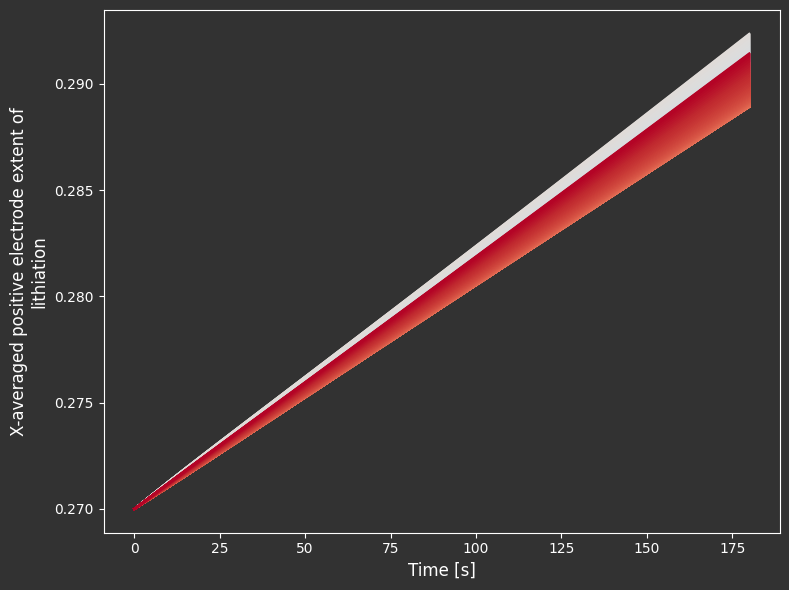

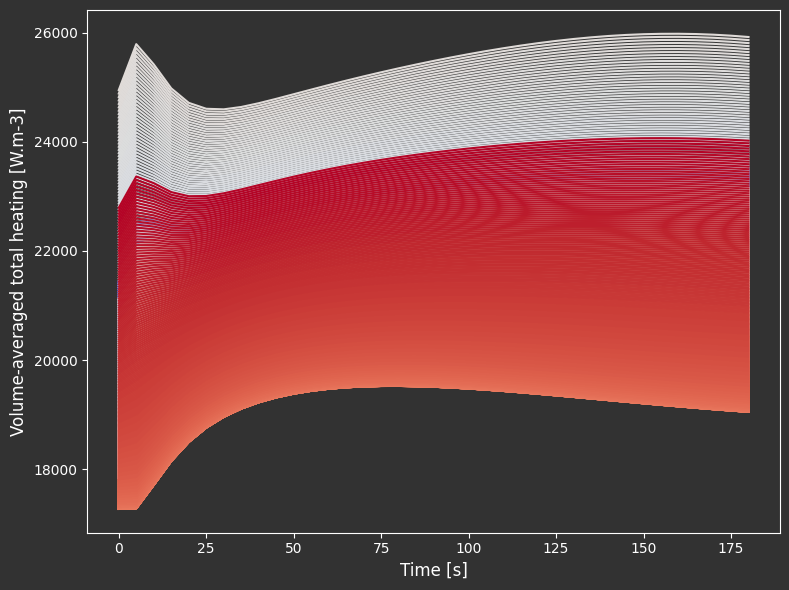

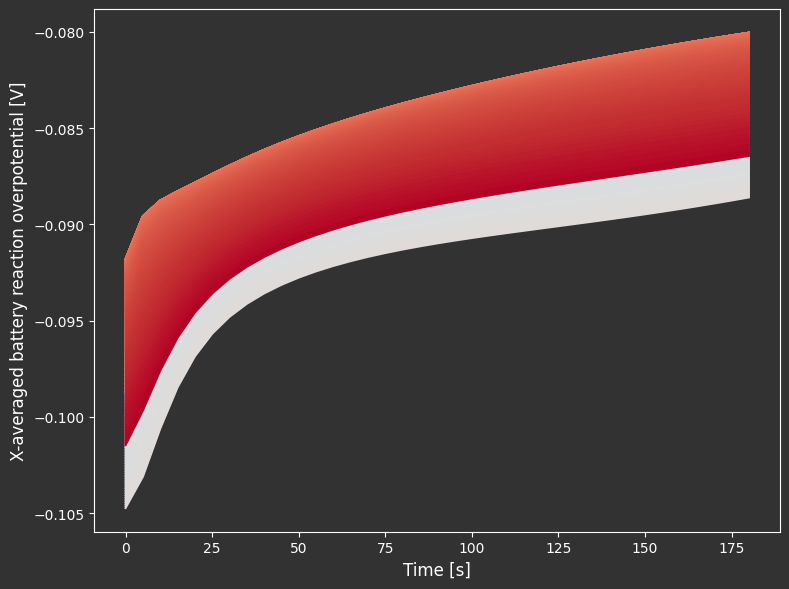

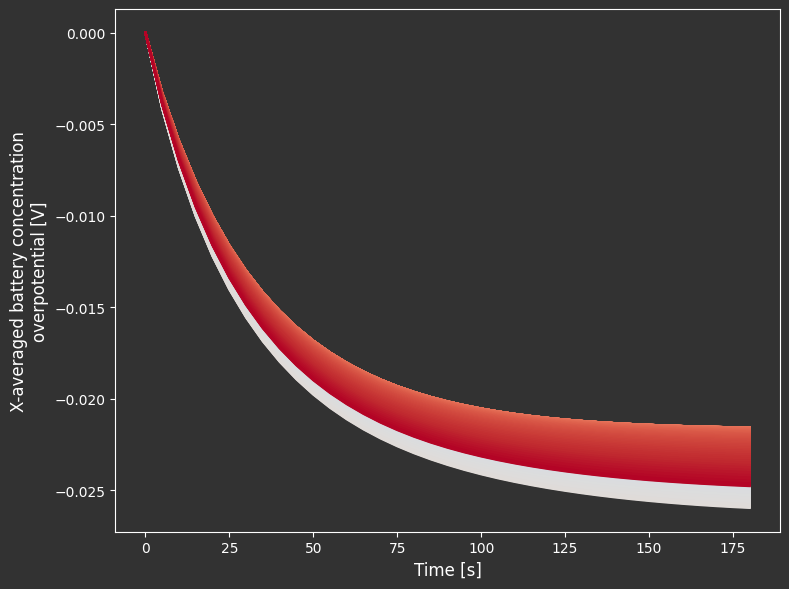

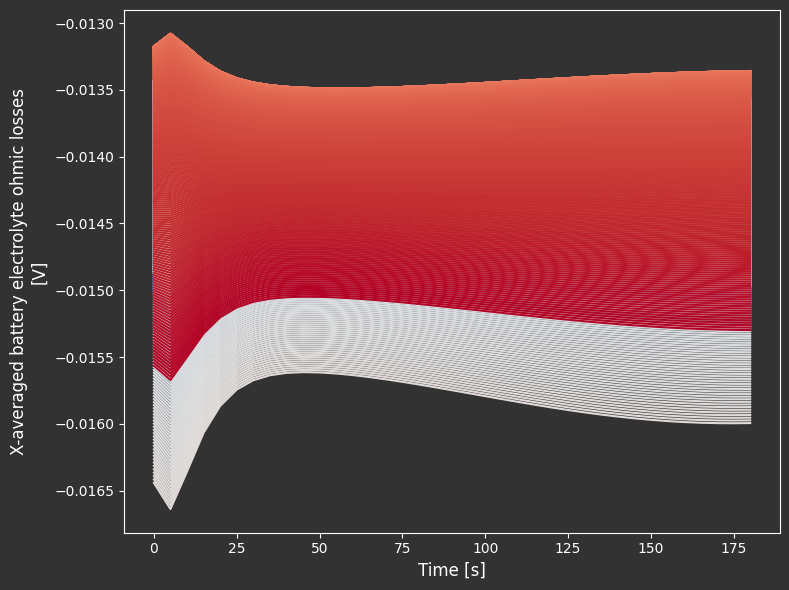

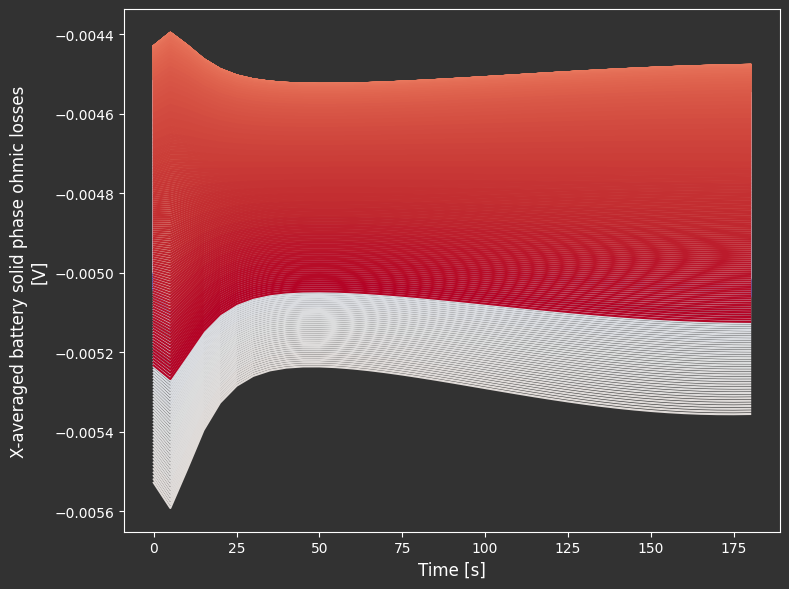

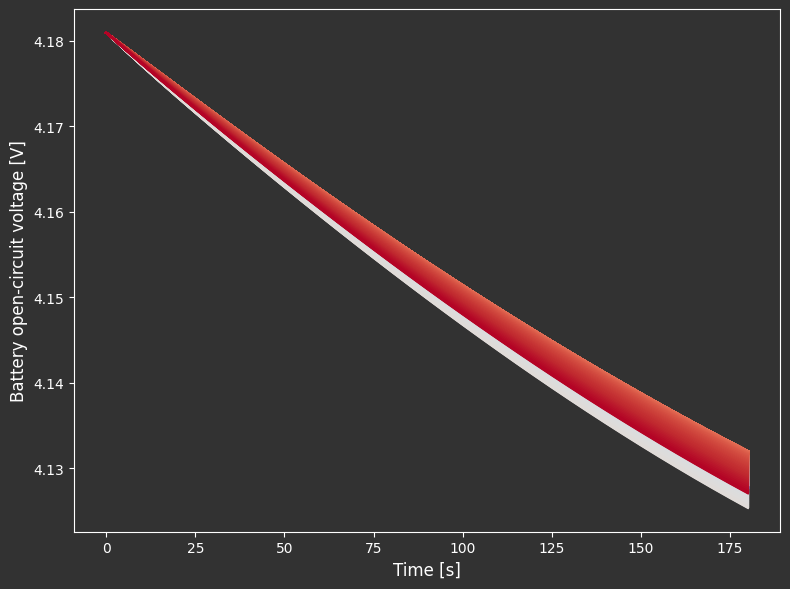

In [8]:
lp.plot_output(output)

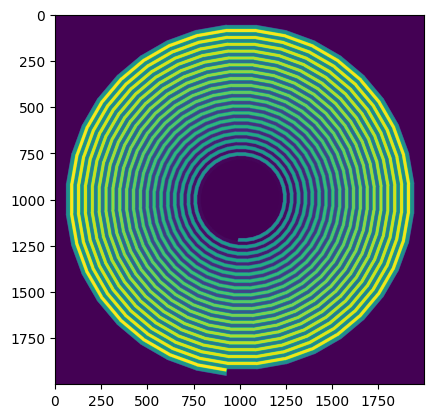

In [9]:
im_spm_map = jellybamm.interpolate_spm_number(project).astype(int)

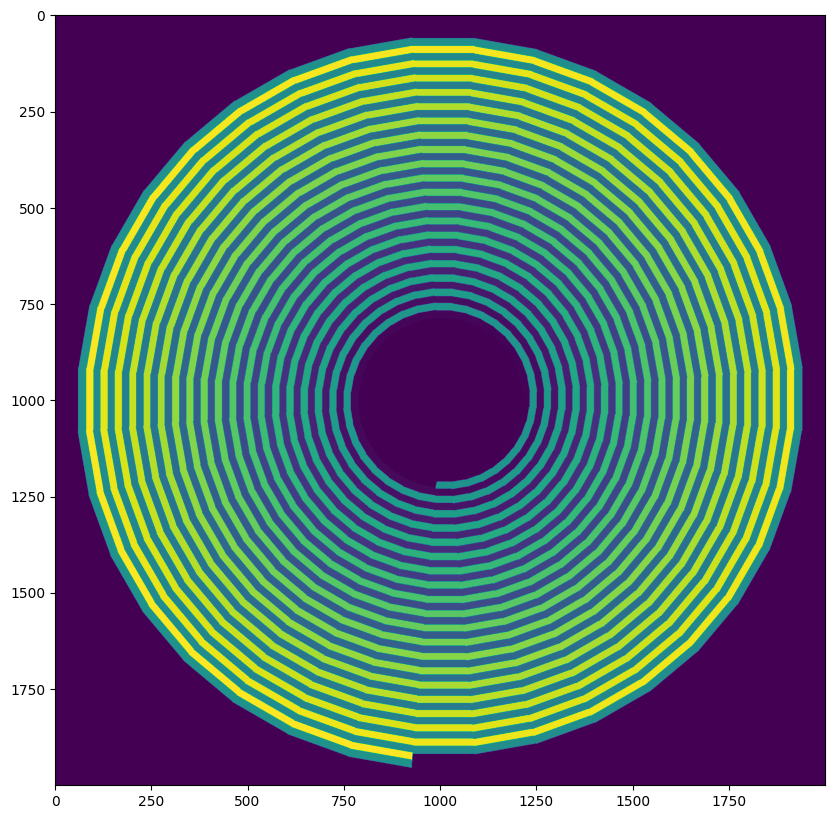

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(im_spm_map)

In [11]:
np.unique(im_spm_map)

array([  -1,    0,    1, ..., 1401, 1402, 1403])

In [12]:
mask = im_spm_map == -1

In [13]:
output.keys()

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Cell current [A]', 'Cell internal resistance [Ohm]', 'Terminal voltage [V]', 'Surface open-circuit voltage [V]', 'Volume-averaged cell temperature [K]', 'Current collector current density [A.m-2]', 'X-averaged negative electrode extent of lithiation', 'X-averaged positive electrode extent of lithiation', 'Volume-averaged total heating [W.m-3]', 'X-averaged battery reaction overpotential [V]', 'X-averaged battery concentration overpotential [V]', 'X-averaged battery electrolyte ohmic losses [V]', 'X-averaged battery solid phase ohmic losses [V]', 'Battery open-circuit voltage [V]'])

In [14]:
t_data = output["Volume-averaged cell temperature [K]"][-1, :]
i_data = output["Current collector current density [A.m-2]"][-1, :]

In [15]:
arr = np.ones_like(im_spm_map).astype(float)

In [16]:
arr[~mask] = t_data[im_spm_map][~mask]
arr[mask] = np.nan

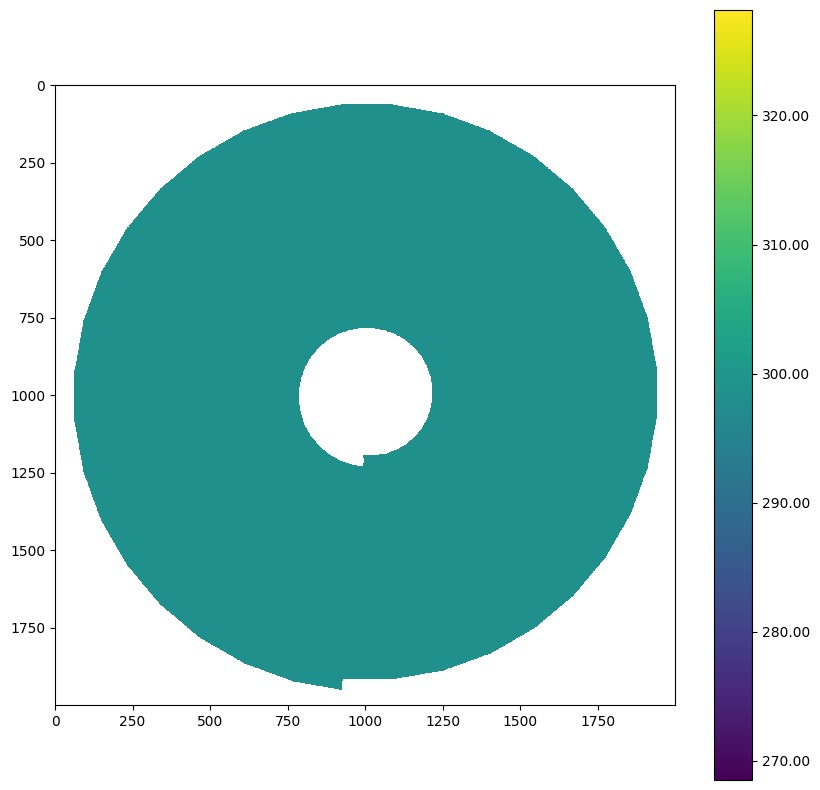

In [17]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
im = ax1.imshow(arr)
cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
cbar.ax.locator_params(nbins=6)

In [19]:
t_data.max() - t_data.min()

0.0